In [42]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 

In [43]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
top10_df = pd.read_csv('Top10ByIncome.csv')

In [44]:
cluster_df = carmax_df
cluster_df = cluster_df.drop('insert_num', axis=1)

## Time to Cluster - Gonna use k-means initially 

In general, we can cluster observations on the basis of the features in order to identify subgroups among the observations, or we can cluster fea- tures on the basis of the observations in order to discover subgroups among the features. In what follows, for simplicity we will discuss clustering obser- vations on the basis of the features, though the converse can be performed by simply transposing the data matrix.

In [45]:
cluster_df = carmax_df
cluster_df = cluster_df.drop('insert_num', axis=1)
cluster_df = cluster_df.drop('customer_age', axis=1)
cluster_df = cluster_df.drop('post_purchase_satisfaction', axis=1)
cluster_df.head()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
0,DODGE,CHARGER,2012,15001.0,20000.0,1,1,40001 - 60000,U,0,8.0,0,1,Twenties,sedan
1,FORD,F150,2007,15001.0,20000.0,0,0,0 - 20000,F,1,19.0,0,0,Fifties,truck
2,BMW,328,2010,25001.0,30000.0,1,1,60001 - 80000,F,1,21.0,0,0,Forties,sedan
3,LEXUS,GS 300,2003,10001.0,15000.0,0,1,20001 - 40000,M,0,8.0,0,0,Twenties,sedan
4,CHEVROLET,CRUZE,2012,15001.0,20000.0,1,1,120001 - 140000,M,1,5.0,1,1,Thirties,sedan


### Convert the Categorical Variables to Numbers

In [46]:
# function to transform into numerical bins by normal/gaussian distribution
def categorical_transform(col):
    classnames, factorval, rank = np.unique(col, return_inverse = True,return_counts = True)
    
    temp = np.array(rank)
    temp.sort()
    temp = np.concatenate((temp[::2], temp[~np.isin(temp,temp[::2])][::-1]))

    category_count = {}
    for i in range(len(classnames)):
        category_count[classnames[i]] = rank[i]
    
    vals = [i * 5 for i in range(len(temp))]
    
    for i in range(len(temp)):
        for key, value in category_count.items():
            if value == temp[i]:
                category_count[key] = vals[i]
            
    check_list = list(col)
    for i in range(len(check_list)):
        for key, value in category_count.items():
            if check_list[i] == key:
                factorval[i] = value 
                break
    
    return category_count, factorval

### Create a dictionary so we can map back 

In [47]:
## references of transformation for later 
references = {}

for i in cluster_df.columns:
    if cluster_df[i].dtype == 'object':
        classes = cluster_df[i]
        references[i], cluster_df[i] = categorical_transform(classes)

### Normalize the Data

In [48]:
from sklearn.preprocessing import StandardScaler

X = cluster_df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.51542182,  0.50585891,  0.99205841, ...,  0.39197982,
        -0.86586251,  0.1769786 ],
       [-0.03933071,  0.10305356, -1.01442395, ..., -0.44812634,
         1.28579862,  0.94494974],
       [-0.77900074,  0.37159046,  0.18946547, ..., -0.44812634,
         0.56857824,  0.1769786 ],
       ...,
       [ 1.25509185,  0.64012736,  0.99205841, ...,  0.39197982,
        -1.58308289, -0.59099254],
       [-0.22424822,  1.19638237, -2.61960984, ..., -0.44812634,
        -0.86586251,  1.71292088],
       [ 0.33050431,  0.1989596 ,  0.99205841, ..., -0.44812634,
        -0.14864214,  0.1769786 ]])

### Cluster the Data into 5 distinct Clusters

In [54]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan")
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 4 1 ... 0 0 0]


In [65]:
k_means.inertia_/cluster_df.shape[0]

11.227201907595324

In [53]:
cluster_df["Labels"] = labels
cluster_df.Labels.unique()

array([4, 0, 3, 1, 2])

### Now that the data has been clustered map back to names

In [55]:
def cat_to_names(df,references):
    temp_df = df.copy()
    for key in references.keys():
        vals = references[key]
        for label_key in vals.keys():
            temp_df[key] = temp_df[key].replace(vals[label_key],label_key)
    return temp_df

In [56]:
cluster_with_names = cat_to_names(cluster_df,references)

In [70]:
cluster_with_names.groupby(['Labels']).agg(pd.Series.mode)

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
Labels,,,,,,,,,,,,,,,
0,TOYOTA,ALTIMA,2010,15001.0,20000.0,0,0,?,M,0,5.0,0,0,Forties,sedan
1,NISSAN,ALTIMA,2010,10001.0,15000.0,0,1,20001 - 40000,M,0,6.0,1,0,Thirties,sedan
2,CHEVROLET,COOPER,2012,15001.0,20000.0,1,1,40001 - 60000,M,0,2396.0,0,0,Twenties,sedan
3,MERCEDES-BENZ,F150,2011,25001.0,30000.0,1,1,40001 - 60000,M,0,5.0,0,0,Forties,suv
4,NISSAN,ALTIMA,2012,15001.0,20000.0,0,1,20001 - 40000,M,0,5.0,0,0,Twenties,sedan


inertia_float
 - Sum of squared distances of samples to their closest cluster center.

When using an optimization algorithm like gradient descent, there is an error that it tries to minimize. While k-means does not explicitly try to minimize some error, we still have a way to measure error. It's called inertia. Inertia is the sum of square distances of samples to their closest cluster center. The smaller the inertia, the better.

In [73]:
counts_of_puchase_models = cluster_with_names.groupby(['Labels','purchase_make']).count().reset_index().rename(columns={"purchase_vehicle_year":"count"})
counts_of_puchase_models

,Labels,purchase_make,purchase_model,count,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
0,0,ACURA,831,831,831,831,831,831,831,831,831,807,831,831,831,831
1,0,AUDI,437,437,437,437,437,437,437,437,437,424,437,437,437,437
2,0,BENTLEY,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,0,BMW,1514,1514,1514,1514,1514,1514,1514,1514,1514,1481,1514,1514,1514,1514
4,0,BUICK,611,611,611,611,611,611,611,611,611,593,611,611,611,611
5,0,CADILLAC,655,655,655,655,655,655,655,655,655,644,655,655,655,655
6,0,CHEVROLET,5974,5974,5974,5974,5974,5974,5974,5974,5974,5785,5974,5974,5974,5974
7,0,CHRYSLER,1808,1808,1808,1808,1808,1808,1808,1808,1808,1758,1808,1808,1808,1808
8,0,DODGE,3467,3467,3467,3467,3467,3467,3467,3467,3467,3365,3467,3467,3467,3467
9,0,FIAT,169,169,169,169,169,169,169,169,169,162,169,169,169,169


In [82]:
var1 = 'purchase_make'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1]).count().reset_index().rename(columns={'trade_in':"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    top10_dfs.append(temp_df.sort_values(by='count',ascending=False).head(2))


top10_dfs = pd.concat(top10_dfs)
top10_dfs

,Labels,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
39,0,TOYOTA,8984,8984,8984,8984,8984,8984,8984,8984,8984,8748,8984,8984,8984,8984
10,0,FORD,8810,8810,8810,8810,8810,8810,8810,8810,8810,8522,8810,8810,8810,8810
69,1,NISSAN,7440,7440,7440,7440,7440,7440,7440,7440,7440,7346,7440,7440,7440,7440
47,1,CHEVROLET,7316,7316,7316,7316,7316,7316,7316,7316,7316,7212,7316,7316,7316,7316
86,2,CHEVROLET,32,32,32,32,32,32,32,32,32,32,32,32,32,32
110,2,TOYOTA,31,31,31,31,31,31,31,31,31,31,31,31,31,31
135,3,MERCEDES-BENZ,6308,6308,6308,6308,6308,6308,6308,6308,6308,6220,6308,6308,6308,6308
121,3,FORD,6148,6148,6148,6148,6148,6148,6148,6148,6148,6044,6148,6148,6148,6148
176,4,NISSAN,21670,21670,21670,21670,21670,21670,21670,21670,21670,21377,21670,21670,21670,21670
185,4,TOYOTA,19734,19734,19734,19734,19734,19734,19734,19734,19734,19487,19734,19734,19734,19734


https://kenzotakahashi.github.io/k-means-clustering-from-scratch-in-python.html#:~:text=It's%20called%20inertia.,smaller%20the%20inertia%2C%20the%20better

In [84]:
var1 = 'customer_gender'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1]).count().reset_index().rename(columns={'trade_in':"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    top10_dfs.append(temp_df.sort_values(by='count',ascending=False).head(3))


top10_dfs = pd.concat(top10_dfs)
top10_dfs

,Labels,customer_gender,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
1,0,M,36723,36723,36723,36723,36723,36723,36723,36723,36723,35681,36723,36723,36723,36723
0,0,F,24068,24068,24068,24068,24068,24068,24068,24068,24068,23468,24068,24068,24068,24068
2,0,U,6346,6346,6346,6346,6346,6346,6346,6346,6346,6158,6346,6346,6346,6346
4,1,M,31464,31464,31464,31463,31463,31464,31464,31464,31464,31041,31464,31464,31464,31464
3,1,F,26554,26554,26554,26554,26554,26554,26554,26554,26554,26213,26554,26554,26554,26554
5,1,U,7214,7214,7214,7214,7214,7214,7214,7214,7214,7095,7214,7214,7214,7214
7,2,M,187,187,187,187,187,187,187,187,187,187,187,187,187,187
6,2,F,106,106,106,106,106,106,106,106,106,106,106,106,106,106
8,2,U,16,16,16,16,16,16,16,16,16,16,16,16,16,16
10,3,M,34855,34855,34855,34855,34855,34855,34855,34855,34855,34301,34855,34855,34855,34855


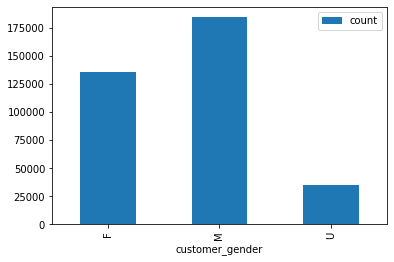

In [90]:
cluster_with_names.groupby('customer_gender').count().reset_index().rename(columns={'purchase_make':'count'}).plot.bar(x='customer_gender',y='count')

In [95]:
var1 = 'customer_gender'
var2 = 'purchase_make'
var3 = 'AgeBin'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1,var2,var3]).count().reset_index().rename(columns={'trade_in':"count"})
counts_of_puchase_models

,Labels,customer_gender,purchase_make,AgeBin,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,purchase_class
0,0,F,ACURA,Eighties,1,1,1,1,1,1,1,1,1,1,1,1
1,0,F,ACURA,Fifties,46,46,46,46,46,46,46,46,46,46,46,46
2,0,F,ACURA,Forties,63,63,63,63,63,63,63,63,62,63,63,63
3,0,F,ACURA,HundredPlus,1,1,1,1,1,1,1,1,1,1,1,1
4,0,F,ACURA,Seventies,7,7,7,7,7,7,7,7,6,7,7,7
5,0,F,ACURA,Sixties,23,23,23,23,23,23,23,23,21,23,23,23
6,0,F,ACURA,Thirties,63,63,63,63,63,63,63,63,58,63,63,63
7,0,F,ACURA,Twenties,57,57,57,57,57,57,57,57,57,57,57,57
8,0,F,ACURA,UnderTwenty,2,2,2,2,2,2,2,2,2,2,2,2
9,0,F,ACURA,Unknown,4,4,4,4,4,4,4,4,1,4,4,4


In [91]:
var1 = 'customer_gender'
var2 = 'purchase_make'
var3 = 'AgeBin'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1,var2,var3]).count().reset_index().rename(columns={'trade_in':"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    top10_dfs.append(temp_df.sort_values(by='count',ascending=False).head(3))


top10_dfs = pd.concat(top10_dfs)
top10_dfs

,Labels,customer_gender,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
1,0,M,36723,36723,36723,36723,36723,36723,36723,36723,36723,35681,36723,36723,36723,36723
0,0,F,24068,24068,24068,24068,24068,24068,24068,24068,24068,23468,24068,24068,24068,24068
2,0,U,6346,6346,6346,6346,6346,6346,6346,6346,6346,6158,6346,6346,6346,6346
4,1,M,31464,31464,31464,31463,31463,31464,31464,31464,31464,31041,31464,31464,31464,31464
3,1,F,26554,26554,26554,26554,26554,26554,26554,26554,26554,26213,26554,26554,26554,26554
5,1,U,7214,7214,7214,7214,7214,7214,7214,7214,7214,7095,7214,7214,7214,7214
7,2,M,187,187,187,187,187,187,187,187,187,187,187,187,187,187
6,2,F,106,106,106,106,106,106,106,106,106,106,106,106,106,106
8,2,U,16,16,16,16,16,16,16,16,16,16,16,16,16,16
10,3,M,34855,34855,34855,34855,34855,34855,34855,34855,34855,34301,34855,34855,34855,34855


In [93]:
cluster_with_names['purchase_class']

0               sedan
1               truck
2               sedan
3               sedan
4               sedan
5               sedan
6               truck
7                 suv
8                 suv
9               sedan
10              sedan
11              sedan
12                suv
13                suv
14              sedan
15              wagon
16                van
17              truck
18              sedan
19              sedan
20                suv
21              sedan
22              sedan
23              sedan
24              truck
25              sedan
26              sedan
27              wagon
28              coupe
29              wagon
             ...     
355844          wagon
355845            suv
355846          sedan
355847          sedan
355848          sedan
355849            suv
355850          wagon
355851            suv
355852            van
355853    convertible
355854          sedan
355855          sedan
355856            suv
355857          wagon
355858    

In [96]:
cluster_dataset[1].sum()

1.3196921813026008